In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from yellowbrick.cluster import KElbowVisualizer

from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from tqdm import tqdm


Loading dataset

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ML/SupermarketData/ECommerce_consumer behaviour.csv')
data.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id,department,product_name
0,2425083,49125,1,2,18,NaN,17,1,0,13,pantry,baking ingredients
1,2425083,49125,1,2,18,NaN,91,2,0,16,dairy eggs,soy lactosefree
2,2425083,49125,1,2,18,NaN,36,3,0,16,dairy eggs,butter
3,2425083,49125,1,2,18,NaN,83,4,0,4,produce,fresh vegetables
4,2425083,49125,1,2,18,NaN,83,5,0,4,produce,fresh vegetables


# Analysing data

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2019501 entries, 0 to 2019500
Data columns (total 12 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   order_number            int64  
 3   order_dow               int64  
 4   order_hour_of_day       int64  
 5   days_since_prior_order  float64
 6   product_id              int64  
 7   add_to_cart_order       int64  
 8   reordered               int64  
 9   department_id           int64  
 10  department              object 
 11  product_name            object 
dtypes: float64(1), int64(9), object(2)
memory usage: 184.9+ MB


In [ ]:
data.shape

(2019501, 12)

We have 2019501 data points with 12 total features

statistical properties: \
(may features are categorical, so these statistical properties may not be useful)

In [ ]:
data.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id
count,2.019501e+06,2.019501e+06,2.019501e+06,2.019501e+06,2.019501e+06,1.895159e+06,2.019501e+06,2.019501e+06,2.019501e+06,2.019501e+06
mean,1.707013e+06,1.030673e+05,1.715138e+01,2.735367e+00,1.343948e+01,1.138603e+01,7.120590e+01,8.363173e+00,5.897427e-01,9.928349e+00
std,9.859832e+05,5.949117e+04,1.752576e+01,2.093882e+00,4.241008e+00,8.970980e+00,3.820727e+01,7.150059e+00,4.918804e-01,6.282933e+00
min,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
25%,8.526490e+05,5.158400e+04,5.000000e+00,1.000000e+00,1.000000e+01,5.000000e+00,3.100000e+01,3.000000e+00,0.000000e+00,4.000000e+00
50%,1.705004e+06,1.026900e+05,1.100000e+01,3.000000e+00,1.300000e+01,8.000000e+00,8.300000e+01,6.000000e+00,1.000000e+00,9.000000e+00
75%,2.559031e+06,1.546000e+05,2.400000e+01,5.000000e+00,1.600000e+01,1.500000e+01,1.070000e+02,1.100000e+01,1.000000e+00,1.600000e+01
max,3.421080e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01,1.340000e+02,1.370000e+02,1.000000e+00,2.100000e+01


Number of unique users, orders, products, and departments

In [ ]:
for col in ['user_id', 'order_id', 'product_id', 'department_id'] :
    print ('Unique {}s: {}'.format(col, data[col].nunique()))

Unique user_ids: 105273
Unique order_ids: 200000
Unique product_ids: 134
Unique department_ids: 21


Null values:

In [ ]:
data.isna().sum()

order_id                       0
user_id                        0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    124342
product_id                     0
add_to_cart_order              0
reordered                      0
department_id                  0
department                     0
product_name                   0
dtype: int64

Filling null values for days sinve prior order with 0, because we can't have negative value

In [ ]:
data.fillna(0, inplace=True)

## Quantitative analysis based on products and departments

### Analysis on basket size

Average basket size

In [ ]:
print('average number of products in basket: {}'.format(data['add_to_cart_order'].mean()))

average number of products in basket: 8.363173377978026


Plotting the freauency of different sizes of baskets

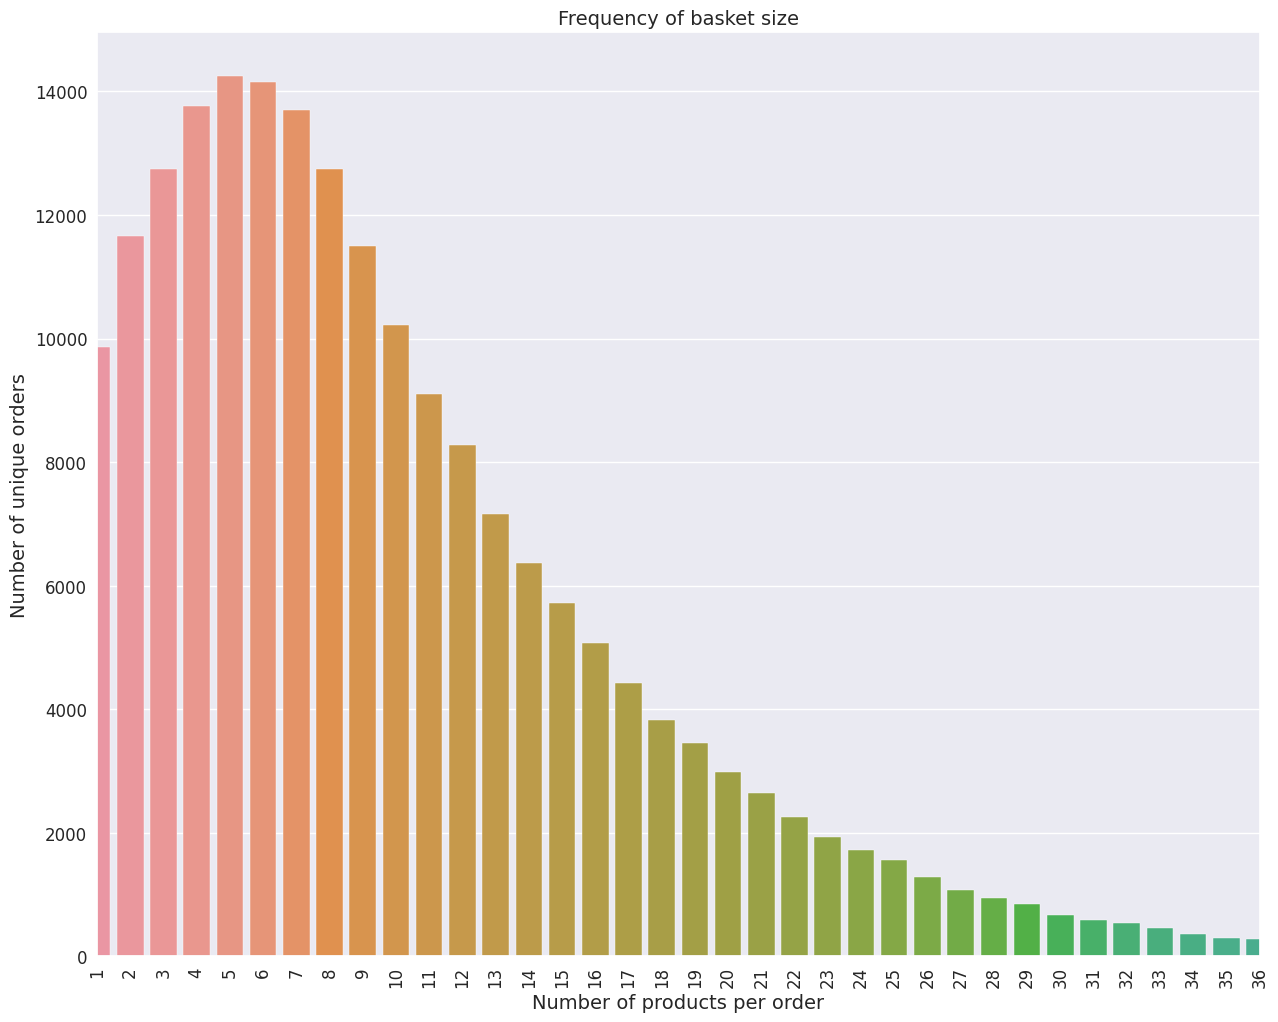

In [ ]:
order_size = data.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
order_size = order_size.add_to_cart_order.value_counts()

sns.set_style('dark')
sns.set_palette("rocket_r")
f, ax = plt.subplots(figsize=(15, 12))
sns.barplot(x=order_size.index, y=order_size.values, ax=ax)
ax.grid(True, axis='y')
plt.xticks(rotation='vertical', fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Number of unique orders', fontsize=14)
plt.xlabel('Number of products per order', fontsize=14)
plt.title('Frequency of basket size', fontsize=14)
plt.xlim(0, 35)  # limit the X axis values to 35
plt.show()
f.savefig('/content/drive/MyDrive/ML/SupermarketData/Frequency_of_basket_size.eps', format='eps')

### Popular products:

In [ ]:
products = data['product_name'].value_counts()
products_df = pd.DataFrame(products).reset_index()
products_df.columns = ['Product', 'Order Count']
top_products = products_df.sort_values(by='Order Count', ascending=False).head()

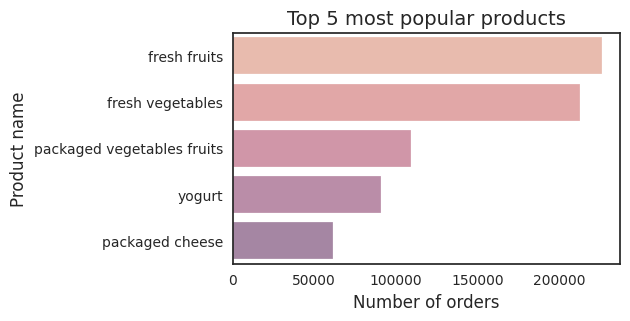

<Figure size 800x550 with 0 Axes>

In [ ]:
plt.figure(figsize = (5, 3))
sns.set_style("ticks")
sns.barplot(data=top_products, x="Order Count", y="Product", palette = 'flare', alpha=0.6)
plt.title("Top 5 most popular products", fontsize=14)
plt.xlabel("Number of orders", fontsize=12)
plt.ylabel("Product name", fontsize=12)
plt.show()
plt.savefig('/content/drive/MyDrive/ML/SupermarketData/top5products.eps', format='eps')

### Popular departments

In [ ]:
departments = data['department'].value_counts()
departments_df = pd.DataFrame(departments).reset_index()
departments_df.columns = ['Department', 'Order Count']
top_departments = departments_df.sort_values(by='Order Count', ascending=False).head()

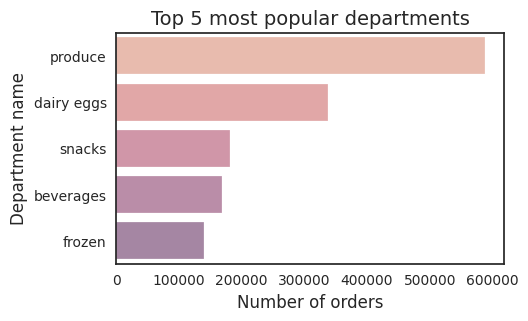

<Figure size 800x550 with 0 Axes>

In [ ]:
plt.figure(figsize = (5, 3))
sns.set_style("ticks")
sns.barplot(data=top_departments, x="Order Count", y="Department", palette = 'flare', alpha=0.6)
plt.title("Top 5 most popular departments", fontsize=14)
plt.xlabel("Number of orders", fontsize=12)
plt.ylabel("Department name", fontsize=12)
plt.show()
plt.savefig('/content/drive/MyDrive/ML/SupermarketData/top5depts.eps', format='eps')

### Products and their popularity in each dapartment

Checking destribution of products in departments

In [ ]:
product_dept_df = pd.crosstab(data['department'], data['product_name'])
product_dept_df

product_name,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
department,,,,,,,,,,,,,,,,,,,,,
alcohol,0,0,0,0,0,0,0,0,0,3002,...,0,0,0,0,0,0,0,0,1893,0
babies,0,0,504,515,23355,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bakery,0,0,0,0,0,2214,0,0,0,0,...,0,0,0,12082,0,0,0,0,0,0
beverages,0,0,0,0,0,0,0,0,0,0,...,0,15733,0,0,0,0,0,52564,0,0
breakfast,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
bulk,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
canned goods,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
dairy eggs,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,90751
deli,0,0,0,0,0,0,0,0,0,0,...,0,0,8003,0,0,0,0,0,0,0


The most popular product of each department:

In [ ]:
product_dept_df.idxmax(axis=1).to_frame(name="Popular products per department")

,Popular products per department
department,
alcohol,beers coolers
babies,baby food formula
bakery,bread
beverages,water seltzer sparkling water
breakfast,cereal
bulk,bulk grains rice dried goods
canned goods,soup broth bouillon
dairy eggs,yogurt
deli,lunch meat


## Analysis based on time

Average waiting before next order

In [ ]:
data['days_since_prior_order'].mean()

10.684989014613016

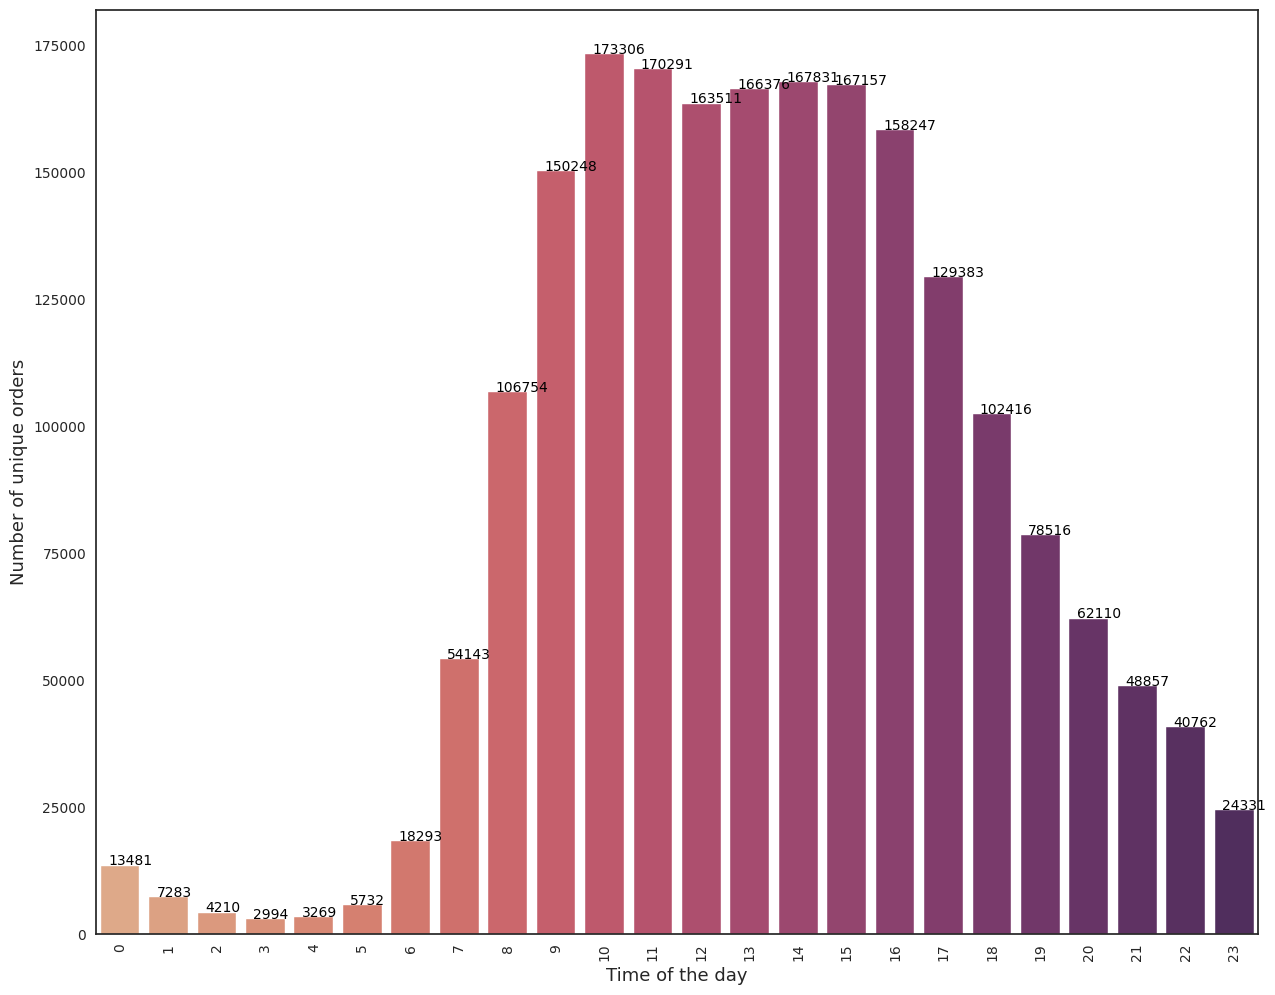

In [ ]:
grouped = data.groupby('order_hour_of_day', as_index=True).agg({'user_id':'count'}).sort_values(by='user_id',ascending=False)


f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='vertical')
sns.barplot(x = grouped.index, y = grouped.user_id, palette='flare')
# sns.color_palette("flare", 10)

plt.ylabel('Number of unique orders', fontsize=13)
plt.xlabel('Time of the day', fontsize=13)

for i in ax.patches:
    ax.text(i.get_x()+0.15, i.get_height()+50, str(round(i.get_height())), fontsize=10, color='black')
plt.show()
f.savefig('/content/drive/MyDrive/ML/SupermarketData/basket_size_freq.eps', format='eps')

Heatmap of hours in week days

<ipython-input-50-c9f0eaec040f>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  day_hour_df_piv = day_hour_df.pivot('order_dow', 'order_hour_of_day', 'order_number')/data.shape[0]


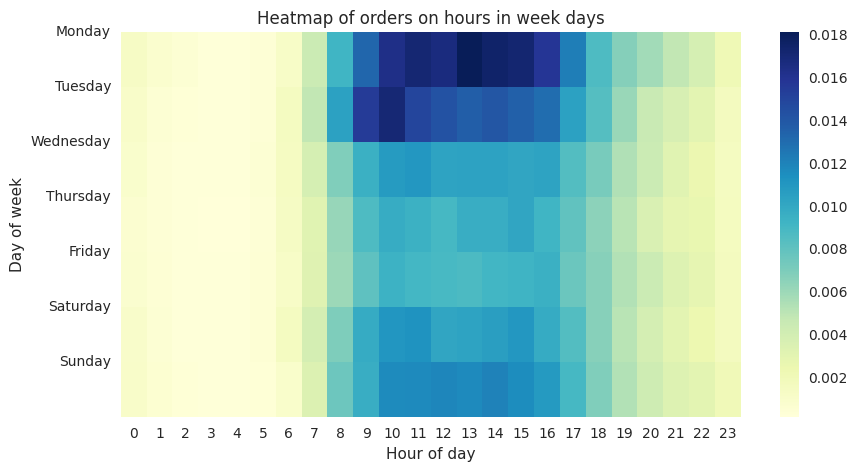

In [ ]:
day_hour_df = data.groupby(["order_dow", "order_hour_of_day"])["order_number"].aggregate("count").reset_index()
day_hour_df_piv = day_hour_df.pivot('order_dow', 'order_hour_of_day', 'order_number')/data.shape[0]

plt.figure(figsize=(10, 5))
sns.heatmap(day_hour_df_piv, cmap='YlGnBu')
plt.yticks([0,1, 2, 3, 4, 5, 6],["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.xlabel("Hour of day")
plt.yticks(rotation=0)
plt.ylabel("Day of week")


plt.title("Heatmap of orders on hours in week days")
plt.savefig('/content/drive/MyDrive/ML/SupermarketData/weekday_hour_heatmap.eps', format='eps')

The two plots above show that: \\
- The busiest time of day is between 10 AM and 4 PM. \\
- Overally, Monday and Tuesday are the most popular days in the week.

two columns *product_name* and *department* are non numerical features. Both of them can be dropped, because we have columns *product_id* and *department_id*.

In [ ]:
data = data.drop(['product_name', 'department'], axis=1)
# the mentioned columns have been dropped in previous runs
data.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,department_id
0,2425083,49125,1,2,18,0.0,17,1,0,13
1,2425083,49125,1,2,18,0.0,91,2,0,16
2,2425083,49125,1,2,18,0.0,36,3,0,16
3,2425083,49125,1,2,18,0.0,83,4,0,4
4,2425083,49125,1,2,18,0.0,83,5,0,4


# Sampling and dimensionality reduction

Because of high size of data, the algorithms are performed on a sample of data with 50000 data points, except where mentioned.

In [ ]:
sample = data.sample(frac=0.025, random_state=42)
sample.shape

(50488, 10)

In [ ]:
standard = StandardScaler().fit_transform(sample)

## PCA

A function to show variance against num of components

In [ ]:
def pca_comp_finder (max_n_comp, data, name) :
    pca_model = PCA (n_components=max_n_comp)
    pca_model.fit(data)
    exp_variance = np.insert(pca_model.explained_variance_ratio_, 0, 0)

    # plot the explained variance
    figure = plt.figure(figsize=(4, 3))

    plt.plot(np.cumsum(exp_variance))
    plt.xticks(range(0,max_n_comp+1))
    plt.xlabel("Number of principal components (PCs)", size=13)
    plt.ylabel("% cumulative variance explained", size=13)
    plt.title("Cumulative variance explained", size=15)

    plt.show()
    plt.savefig('/content/drive/MyDrive/ML/SupermarketData/pcaCompFinder{}.eps'.format(name), format='eps')

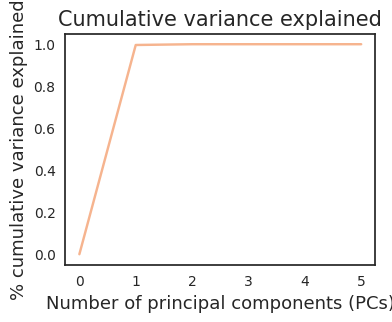

<Figure size 800x550 with 0 Axes>

In [ ]:
pca_comp_finder(5, sample, 'sample')

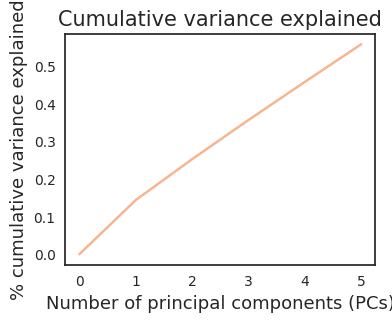

<Figure size 800x550 with 0 Axes>

In [ ]:
pca_comp_finder(5, standard, 'standardscaled')

## Dimesion reduced data using PCA

We use PCA with 2 components for sampled data to reduce its dimension. We don't use PCA for scaled data because of its lack of power to save properties of data.

In [ ]:
pca_mod = PCA(n_components=2)

sample_pca = pd.DataFrame(data=pca_mod.fit_transform(sample),
                        columns=['PC1', 'PC2'])

# view data frame of PCs
sample_pca.head()

,PC1,PC2
0,-4.542710e+05,-48809.922233
1,1.351200e+06,58585.816910
2,5.447959e+05,-65818.711196
3,-1.519439e+06,-59224.455393
4,9.200861e+05,-69373.850119


In [ ]:
pca_standard = PCA(n_components=2)

standard_pca = pd.DataFrame(data=pca_standard.fit_transform(standard),
                        columns=['PC1', 'PC2'])

# view data frame of PCs
standard_pca.head()

,PC1,PC2
0,-0.482240,-1.284549
1,-1.989711,-2.067067
2,-1.056143,0.888711
3,-2.097909,0.852958
4,-0.511659,-0.562506


## T-SNE

In [ ]:
tsne2d = TSNE(n_components=2, random_state=42)
sample_tsne2d = tsne2d.fit_transform(sample)
pd.DataFrame(sample_tsne2d, columns=['T1', 'T2']).to_csv('/content/drive/MyDrive/ML/SupermarketData/sampleTsne2d', index=False)


In [ ]:
sample_pca_tsne2d_mod  = TSNE(n_components=2, random_state=42)
sample_pca_tsne2d = sample_pca_tsne2d_mod.fit_transform(sample_pca)
pd.DataFrame(sample_pca_tsne2d, columns=['T1', 'T2']).to_csv('/content/drive/MyDrive/ML/SupermarketData/sample_pcaTsne2d', index=False)


# Clustering algorithms

In [ ]:
def cluster_visual2d (tsne_data, trained_model, Algotext):
    plt.figure(figsize=(8, 6))
    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=trained_model.labels_, cmap='viridis')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('Clustering Results with {}'.format(Algotext))
    plt.colorbar(label='Cluster')
    plt.show()
    plt.savefig('/content/drive/MyDrive/ML/SupermarketData/cluster_visual2d {}.eps'.format(Algotext), format='eps')


## Kmeans algorithm

### kelbow and silhouettte visualizer

A function for visualizing the elbow method and also, silhouette scores plot

In [ ]:
def kelbow_with_silhouette (dataset, k_range, name) :
    silhouette_scores = []
    inertia = []
    start, end = k_range
    k_values = range(start, end)


    for k in tqdm(k_values):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(dataset)
        inertia.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(dataset, kmeans.labels_))

    # Plotting inertia and silhouette score
    fig , (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
    ax1.plot(k_values, inertia, marker='o')
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('Inertia')
    ax1.set_title('Inertia vs. Number of Clusters')

    ax2.plot(k_values, silhouette_scores, marker='o')
    ax2.set_xlabel('Number of clusters (k)')
    ax2.set_ylabel('Silhouette Score')
    ax2.set_title('Silhouette Score vs. Number of Clusters')

    plt.tight_layout()
    fig.show()
    plt.savefig('/content/drive/MyDrive/ML/SupermarketData/_with_silhouette_{}.eps'.format(name), format='eps')

    return inertia, silhouette_scores

In [ ]:
def kelbow (dataset, k_range, name) :
    inertia = []
    start, end = k_range
    k_values = range(start, end)


    for k in tqdm(k_values):
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(dataset)
        inertia.append(kmeans.inertia_)

    # Plotting inertia and silhouette score
    fig = plt.figure(figsize=(4,4))
    plt.plot(k_values, inertia, marker='o')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Inertia vs. Number of Clusters')

    plt.show()
    plt.savefig('/content/drive/MyDrive/ML/SupermarketData/kelbow_{}.eps'.format(name), format='eps')


### Kmeans on data sample:

finding number of k:

  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 12%|█▎        | 1/8 [00:30<03:35, 30.78s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 25%|██▌       | 2/8 [01:00<03:02, 30.43s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 38%|███▊      | 3/8 [01:31<02:33, 30.60s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change 

([1.2424401300355376e+16,
  5592350533154520.0,
  3256622028617857.5,
  2148378872226118.8,
  1537603787885794.0,
  1185442577048168.0,
  951882041779708.8,
  783827564616003.0],
 [0.6183544131393933,
  0.5775963786658093,
  0.548368930103476,
  0.5287861029786056,
  0.5147826352429185,
  0.49741521634820457,
  0.48250909700447275,
  0.4722541140127287])

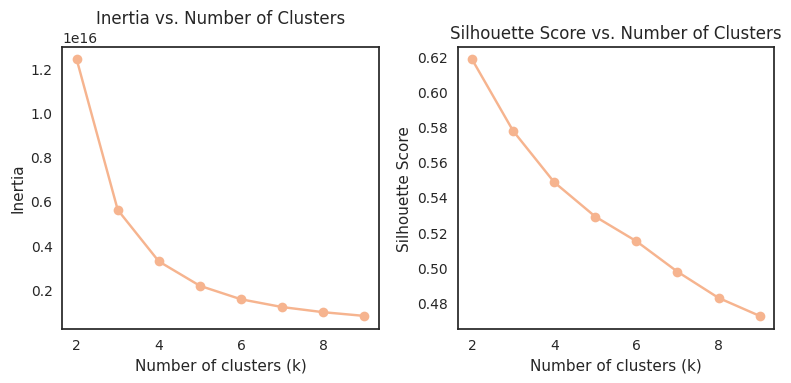

In [ ]:
kelbow_with_silhouette(sample, (2,10), "_sample")

If we consider only inertias plot, we can use 4 as the number of clusters, but its obvious that silhouette is higher in 2 clusters

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


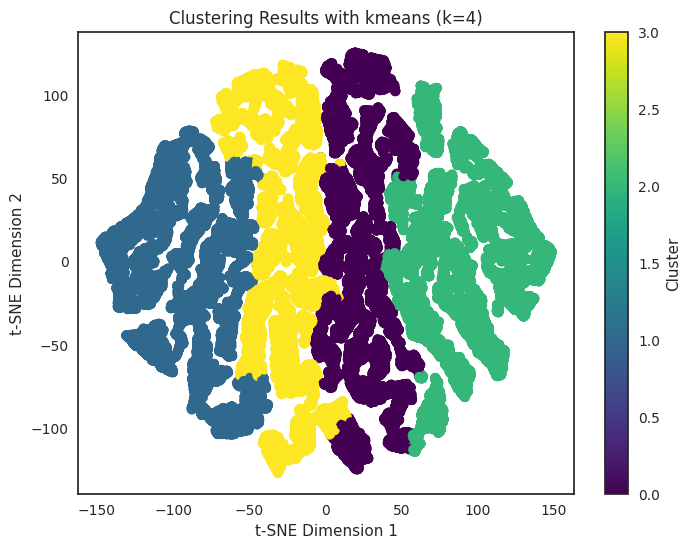

4means 	 silhouette: 0.5483612974645116


<Figure size 800x550 with 0 Axes>

In [ ]:
kmeans4_sample = KMeans(n_clusters=4, init="k-means++")
labels_4means_sample = kmeans4_sample.fit_predict(sample)
cluster_visual2d (sample_tsne2d, kmeans4_sample, 'kmeans (k=4)')
silhouette_4means_sample = silhouette_score(sample, labels_4means_sample)
print('4means \t silhouette: {}'.format(silhouette_4means_sample))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


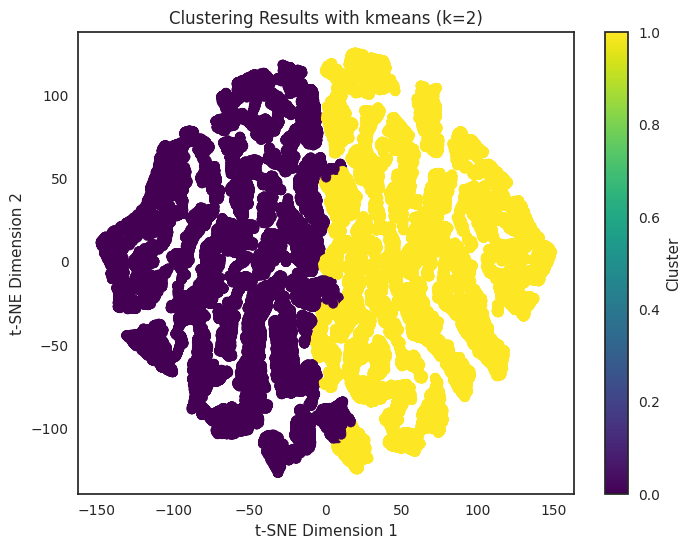

2means 	 silhouette: 0.6183544083270778


<Figure size 800x550 with 0 Axes>

In [ ]:
kmeans2_sample = KMeans(n_clusters=2, init="k-means++")
labels_2means_sample = kmeans2_sample.fit_predict(sample)
cluster_visual2d (sample_tsne2d, kmeans2_sample, 'kmeans (k=2)')
silhouette_2means_sample = silhouette_score(sample, labels_2means_sample)
print('2means \t silhouette: {}'.format(silhouette_2means_sample))

### KMeans on dimension reduced data sample with PCA

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


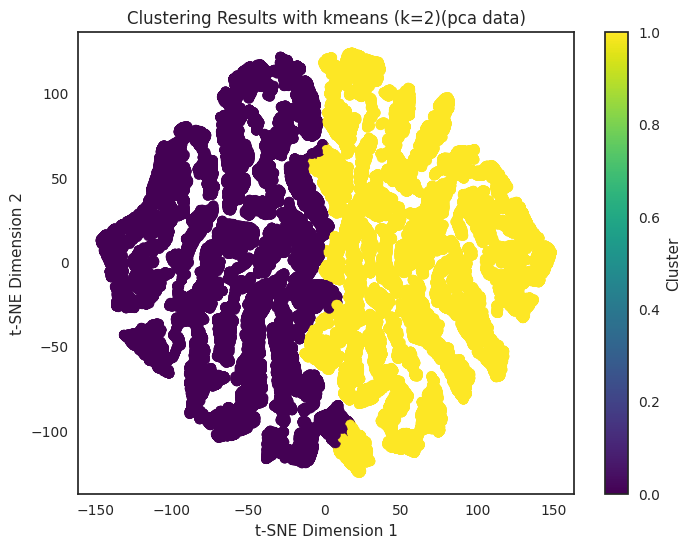

2means 	 silhouette: 0.6183516674741173


<Figure size 800x550 with 0 Axes>

In [ ]:
kmeans2_pca = KMeans(n_clusters=2, init="k-means++")
labels_2means_pca = kmeans2_pca.fit_predict(sample_pca)
cluster_visual2d (sample_pca_tsne2d, kmeans2_pca, 'kmeans (k=2)(pca data)')
silhouette_2means_pca = silhouette_score(sample, labels_2means_pca)
print('2means \t silhouette: {}'.format(silhouette_2means_pca))

## Gaussian Mixture Model

silhouette score: 0.5479399629738032


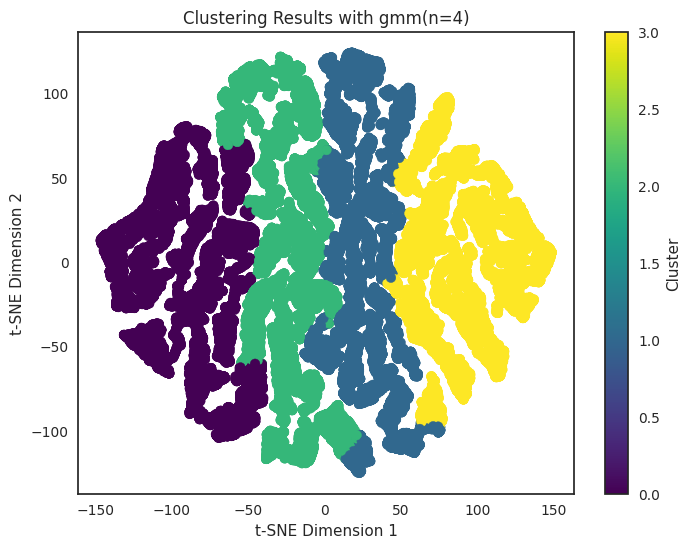

<Figure size 800x550 with 0 Axes>

In [ ]:
gmm = GaussianMixture(n_components=4)
gmm_labels = gmm.fit_predict(sample_pca)
silhouette_gmm = silhouette_score(sample_pca, gmm_labels)
print('silhouette score:', silhouette_gmm)

plt.figure(figsize=(8, 6))
plt.scatter(sample_pca_tsne2d[:, 0], sample_pca_tsne2d[:, 1], c=gmm_labels, cmap='viridis')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Clustering Results with gmm(n=4)')
plt.colorbar(label='Cluster')
plt.show()
plt.savefig('/content/drive/MyDrive/ML/SupermarketData/cluster_visual2d_gmm(n=4).eps', format='eps')


silhouette score: 0.618324994676093


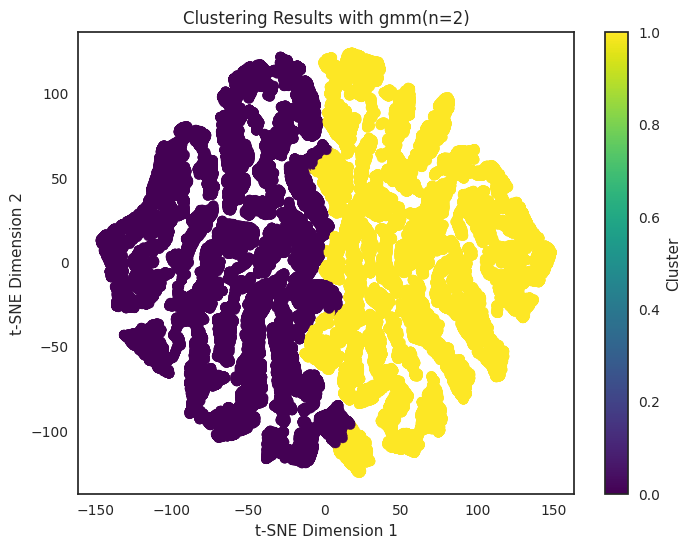

<Figure size 800x550 with 0 Axes>

In [ ]:
gmm = GaussianMixture(n_components=2)
gmm_labels = gmm.fit_predict(sample_pca)
silhouette_gmm = silhouette_score(sample_pca, gmm_labels)
print('silhouette score:', silhouette_gmm)

plt.figure(figsize=(8, 6))
plt.scatter(sample_pca_tsne2d[:, 0], sample_pca_tsne2d[:, 1], c=gmm_labels, cmap='viridis')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('Clustering Results with gmm(n=2)')
plt.colorbar(label='Cluster')
plt.show()
plt.savefig('/content/drive/MyDrive/ML/SupermarketData/cluster_visual2d_gmm(n=2).eps', format='eps')
